In [ ]:
# 蓝色：相关无前提关系（-2）
# 红色：反向前提（-1）
# 灰色：无关系（0）
# 绿色：正向前提（1）
# 紫色：互为前提（2）

In [ ]:
from dataset import Dataset
import numpy as np

def get_evaluation_statistics(df_data, valid_index, predict_style = 'comparison'):
    predicts = df_data[predict_style][valid_index] # predict_style = prediction
    majority_votes = df_data.majority_vote[valid_index]
    # llm 为 是，predict 为 是
    tp = np.sum((majority_votes == 1) & (predicts == 1)) + np.sum((majority_votes == -1) & (predicts == -1)) + np.sum((majority_votes == 2) & (predicts.isin([-1, 1])))
    # llm 为 不是，predict 为 是
    fp = np.sum((majority_votes.isin([-2, 0])) & (predicts != 0))
    # llm 为 不是，predict 为 不是
    tn = np.sum((majority_votes.isin([-2, 0])) & (predicts == 0))
    # llm 为 是，predict 为 不是
    fn = np.sum((majority_votes == 1) & (predicts != 1)) + np.sum((majority_votes == -1) & (predicts != -1)) + np.sum((majority_votes == 2) & (predicts==0))
    
    return tp, fp, tn, fn

openalex_dataset = Dataset()
llm_prereq_relations = openalex_dataset.get_llm_relations(debug = True, revision = False)
llm_prereq_relations[['concept_a','concept_b','majority_vote','related','positive','negative','comparison','prediction']]

file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/edges/level_1_concepts.csv exists and override
column norm matrix shape (303, 303)
df_thresh_values.shape[0]=876
nodes 256
edge shape (2551, 3)
Graph nodes 256
Graph edges 2551
file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/llm_prerequisite_relations_update_comparison_CVM_0.98_CFM_0.5.csv exists and no override (did not save)


,concept_a,concept_b,majority_vote,related,positive,negative,comparison,prediction
0,Public economics,Physical geography,0,0,1,1,0,0
1,Public economics,Finance,-2,1,23,19,1,0
2,Public economics,Economic policy,1,1,12,17,-1,0
3,Public economics,Anatomy,0,0,1,4,-1,0
4,Public economics,Statistics,-1,1,16,16,0,0
...,...,...,...,...,...,...,...,...
45748,Thermodynamics,Environmental health,-2,1,30,12,1,0
45749,Thermodynamics,Physical medicine and rehabilitation,0,0,3,7,-1,0
45750,Pharmacology,Environmental health,-2,1,996,640,1,1
45751,Pharmacology,Physical medicine and rehabilitation,1,1,290,189,1,0


file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/figures/llm_vs_comparison_overall_0.pdf exists and override


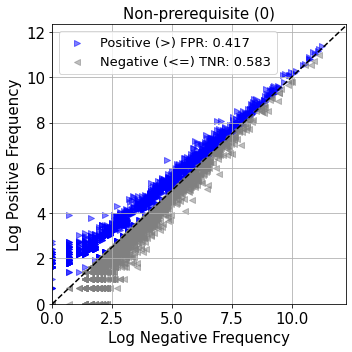

file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/figures/llm_vs_comparison_overall_1.pdf exists and override


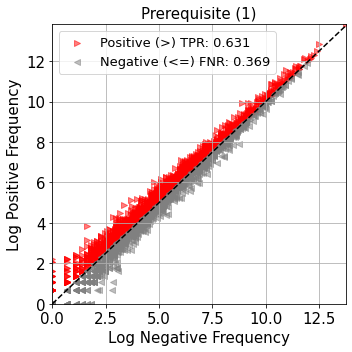

In [4]:
openalex_dataset.visualization.plot_concept_relations_v2(llm_prereq_relations, value_column = 'majority_vote', combine_pos_neg=True, combine_neg2_zero = True, sample_points=True, save_pdf=True, file_name_prefix = 'llm_vs_comparison_overall', combine_fig=False)

In [11]:
import numpy as np
import pandas as pd
value_frequency = llm_prereq_relations.max_frequency.value_counts().sort_values()
unique_values = value_frequency.index.tolist()
unique_values.sort(reverse=True)
n_prerequisites = llm_prereq_relations.majority_vote.isin([-1, 1, 2]).sum()
n_non_prerequisites = (llm_prereq_relations.majority_vote.isin([-2, 0])).sum()

tps = []
fps = []
fns = []
value_records = []
for threshold in unique_values:
    valid_index = llm_prereq_relations.max_frequency >= threshold
    tp, fp, tn, fn = get_evaluation_statistics(llm_prereq_relations, valid_index)
    value_records.append([threshold, tp, fp, tn, fn, tp+fp+tn+fn, valid_index.sum()])
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)

df_records = pd.DataFrame(value_records, columns=['threshold', 'tp', 'fp', 'tn', 'fn', 'sum', 'total'])
df_records

,threshold,tp,fp,tn,fn,sum,total
0,996599,1,0,0,0,1,1
1,371584,2,0,0,0,2,2
2,261421,3,0,0,0,3,3
3,226302,3,1,0,0,4,4
4,224798,4,1,0,0,5,5
...,...,...,...,...,...,...,...
3186,4,1660,29757,1160,851,33428,33428
3187,3,1672,31627,1424,869,35592,35592
3188,2,1698,33796,1848,892,38234,38234
3189,1,1740,36295,2749,929,41713,41713


file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/figures/sample_variational_ROC_curve_comparison_vs_llm.pdf exists and override


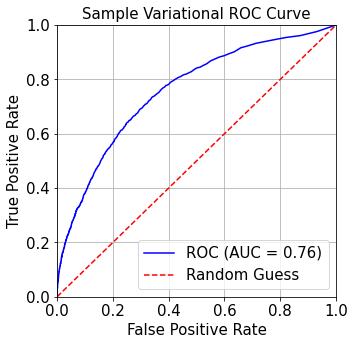

In [13]:
# 混淆矩阵
        #    Positive  Negative
# True         TP         FN
# False        FP         TN

# TPR = TP/(TP+FN)
# FPR = FP/(FP+TN)
tprs = np.array(tps) / tps[-1]
fprs = np.array(fps) / fps[-1]
openalex_dataset.visualization.plot_prerequisite_roc(tprs, fprs, save_pdf = True)

In [1]:
from dataset import Dataset
from param_class import Params_community_concept_pairs, Params_concept_flow_matrix
openalex_dataset = Dataset()
llm_prereq_relations_0 = openalex_dataset.get_llm_relations(debug = False, params = Params_community_concept_pairs(concept_level = 1, less_than = True, select_mode = 'collective'),
                        concept_flow_params = Params_concept_flow_matrix(disciplines = [], row_normalize=False, matrix_value_cumsum_ratio = 0.94, matrix_value_count_cumsum_ratio=0.1, 
                                                                                                matrix_filter = True, matrix_imshow = False, graph_show=False, layout = "graphviz", save_G_concept_flow = False, 
                                                                                                old_matrix_version = False), revision=True)
llm_prereq_relations_1 = openalex_dataset.get_llm_relations(debug = False, params = Params_community_concept_pairs(concept_level = 1, less_than = True, select_mode = 'collective'),
                        concept_flow_params = Params_concept_flow_matrix(disciplines = [], row_normalize=False, matrix_value_cumsum_ratio = 0.95, matrix_value_count_cumsum_ratio=0.2, 
                                                                                                matrix_filter = True, matrix_imshow = False, graph_show=False, layout = "graphviz", save_G_concept_flow = False, 
                                                                                                old_matrix_version = False), revision=True)
llm_prereq_relations_2 = openalex_dataset.get_llm_relations(debug = False, params = Params_community_concept_pairs(concept_level = 1, less_than = True, select_mode = 'collective'),
                        concept_flow_params = Params_concept_flow_matrix(disciplines = [], row_normalize=False, matrix_value_cumsum_ratio = 0.96, matrix_value_count_cumsum_ratio=0.3, 
                                                                                                matrix_filter = True, matrix_imshow = False, graph_show=False, layout = "graphviz", save_G_concept_flow = False, 
                                                                                                old_matrix_version = False), revision=True)
llm_prereq_relations_3 = openalex_dataset.get_llm_relations(debug = False, params = Params_community_concept_pairs(concept_level = 1, less_than = True, select_mode = 'collective'),
                        concept_flow_params = Params_concept_flow_matrix(disciplines = [], row_normalize=False, matrix_value_cumsum_ratio = 0.97, matrix_value_count_cumsum_ratio=0.4, 
                                                                                                matrix_filter = True, matrix_imshow = False, graph_show=False, layout = "graphviz", save_G_concept_flow = False, 
                                                                                                old_matrix_version = False), revision=True)
llm_prereq_relations_4 = openalex_dataset.get_llm_relations(debug = False, params = Params_community_concept_pairs(concept_level = 1, less_than = True, select_mode = 'collective'),
                        concept_flow_params = Params_concept_flow_matrix(disciplines = [], row_normalize=False, matrix_value_cumsum_ratio = 0.98, matrix_value_count_cumsum_ratio=0.5, 
                                                                                                matrix_filter = True, matrix_imshow = False, graph_show=False, layout = "graphviz", save_G_concept_flow = False, 
                                                                                                old_matrix_version = False), revision=True)

file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/edges/level_1_concepts.csv exists and override
nodes 225
edge shape (531, 3)
Graph nodes 225
Graph edges 531
file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/edges/level_1_concepts.csv exists and override
nodes 230
edge shape (564, 3)
Graph nodes 230
Graph edges 564
file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/edges/level_1_concepts.csv exists and override
nodes 236
edge shape (603, 3)
Graph nodes 236
Graph edges 603
file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/edges/level_1_concepts.csv exists and override
nodes 243
edge shape (644, 3)
Graph nodes 243
Graph edges 644
file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/edges/level_1_concepts.csv exists and override
nodes 250
edge shape (715, 3)
Graph nodes 250
Graph edges 715


file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/figures/contingency_tables.pdf exists and override


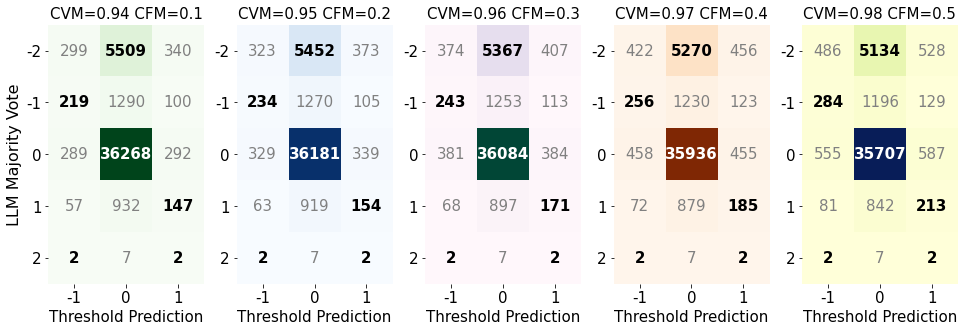

In [2]:
df_list = [llm_prereq_relations_0, llm_prereq_relations_1, llm_prereq_relations_2, llm_prereq_relations_3, llm_prereq_relations_4]
highlight_value_pairs = [(-1, -1), (-1, 2), (0, -2), (0, 0), (1, 1), (1, 2)]
titles = [f'CVM={0.94} CFM={0.1}', f'CVM={0.95} CFM={0.2}', f'CVM={0.96} CFM={0.3}', f'CVM={0.97} CFM={0.4}', f'CVM={0.98} CFM={0.5}']
openalex_dataset.visualization.plot_multiple_contingency_heatmaps_plt(df_list, highlight_value_pairs, 15, base_width = 0.9, titles=titles, n_cols=5, grid_visible=False, save_pdf=True)

file: /home/OpenAlex-Analysis/Prerequisite-Learning/files/figures/contingency_tables.pdf exists and override


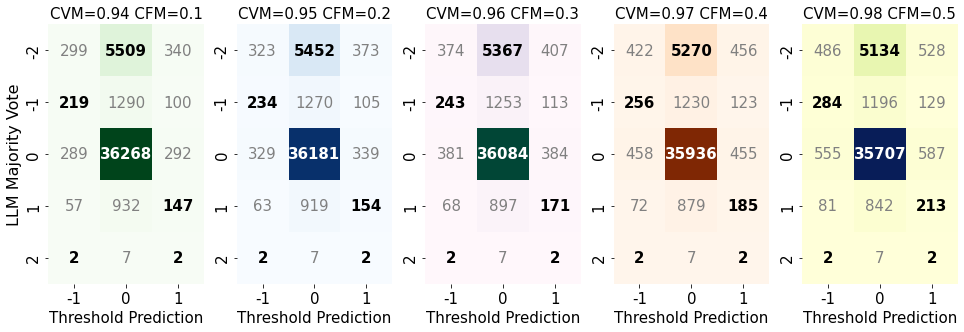

In [2]:
df_list = [llm_prereq_relations_0, llm_prereq_relations_1, llm_prereq_relations_2, llm_prereq_relations_3, llm_prereq_relations_4]
highlight_value_pairs = [(-1, -1), (-1, 2), (0, -2), (0, 0), (1, 1), (1, 2)]
titles = [f'CVM={0.94} CFM={0.1}', f'CVM={0.95} CFM={0.2}', f'CVM={0.96} CFM={0.3}', f'CVM={0.97} CFM={0.4}', f'CVM={0.98} CFM={0.5}']
openalex_dataset.visualization.plot_multiple_contingency_heatmaps_sns(df_list, highlight_value_pairs, 15, base_width = 0.9, titles=titles, n_cols=5, grid_visible=False, save_pdf=True)